In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('whitegrid',
              {'grid.linestyle': ':', 'grid.color': 'red', 'axes.edgecolor': '0.5',
               'axes.linewidth': 1.2, 'legend.frameon': True})


In [2]:
from scipy.constants import e, m_p, c

from scipy.constants import physical_constants

In [3]:
from cpymad.madx import Madx

import pysixtrack.line
import sixtracklib as pyst

### $\implies$ hard coded apertures in PySixTrackLib!!!

In [4]:
madx = Madx()
madx.options.echo = False
# madx.options.warn = False
# madx.options.info = False


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.09.13 10:55:26      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [5]:
madxwarn = madx.options.warn
madx.options.warn = False
madx.call('./SIS100RING_220618_nodipedge.thin.seq')
    #'./SIS100_RF_220618_9slices.thin.seq')
madx.call('./OpticsYEH_BeamParameters.str')
madx.options.warn = madxwarn

In [6]:
nmass = physical_constants['atomic mass constant energy equivalent in MeV'][0] * 1e-3
nmass = 0.931494061 # MAD-X value

In [7]:
madx.command.beam(particle='ion', mass=238*nmass, charge=28, energy=238*0.2+238*nmass)

True

In [8]:
madx.use(sequence='sis100ring')

adding errors:

In [9]:
madx.call('Coll+Errors+BeamDistr.madx')

In [10]:
len(madx.sequence.sis100ring.elements)

1804

Proper dipedges (as well as elseparators, kickers and collimators) are not supported in SixTrackLib yet:

In [11]:
# madx.input('''
# select, flag=seqedit, class=collimator;
# !select, flag=seqedit, class=hmonitor;
# !select, flag=seqedit, class=vmonitor;
# select, flag=seqedit, class=kicker;
# !select, flag=seqedit, class=tkicker;
# select, flag=seqedit, class=dipedge;
# select, flag=seqedit, class=elseparator;

# seqedit, sequence=SIS100RING;
#     remove, element=selected;
#     flatten;
# endedit;
# ''')

In [12]:
madx.use(sequence='sis100ring')

In [13]:
# madx.command.eoption(add=True, seed=1)

In [14]:
# madx.command.exec('EA_EFCOMP_MH()')

In [15]:
# for s in range(1, 10):
#     assert madx.command.exec(f'EA_rEFCOMP_QD({s},1)')

In [16]:
madx.command.readtable(file='/home/oeftiger/gsi/vera_sc/noSC_errors/only-DX-ealign/errors_84_73_1', table='efield')

Want to make named table: efield


True

In [17]:
madx.command.seterr(table='efield')

Want to use named table: efield
The table ==> efield <=== was found 


True

In [18]:
madx.input('''
match, sequence=SIS100RING;
global, sequence=SIS100RING, q1=18+0.84, q2=18+0.73;
vary, name=kqf, step=0.00001;
vary, name=kqd, step=0.00001;
lmdif, calls=500, tolerance=1.0e-10;
endmatch;
''')

START MATCHING

number of sequences: 1
sequence name: sis100ring
number of variables:    2
user given constraints: 2
total constraints:      2

START LMDIF:


MATCH SUMMARY

Node_Name                  Constraint   Type  Target Value       Final Value        Penalty
--------------------------------------------------------------------------------------------------


Final Penalty Function =   1.24754851e-11





Variable                 Final Value  Initial Value Lower Limit  Upper Limit 
--------------------------------------------------------------------------------
kqf                       2.80433e-01  2.81571e-01 -1.00000e+20  1.00000e+20
kqd                      -2.80404e-01 -2.80616e-01 -1.00000e+20  1.00000e+20

END MATCH SUMMARY

VARIABLE "TAR" SET TO   1.24754851e-11


True

In [19]:
twiss = madx.twiss();

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0     0.004018991724        15.77398575 

                q1                dq1            betxmax              dxmax 
       18.83999999       -36.55068145        19.92719879        3.811450544 

             dxrms             xcomax             xcorms                 q2 
       1.428756471     0.003953926449      0.00193457678        18.73000035 

               dq2            betymax              dymax              dyrms 
      -42.74765922        21.35174844      0.04575006961      0.01743588586 

            ycomax             ycorms             deltap            synch_1 
   5.325035209e-05    2.205876519e-05                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

            nflips 
          

In [20]:
madx.input('cavity_voltage = 58.2/1000/number_cavities;')

True

In [21]:
madx.use(sequence='sis100ring')

In [22]:
sis100 = madx.sequence.sis100ring

Read in errors for adding them in PySixTrack:

In [21]:
# #filename_error_table = "./errors_84_73_1"
# filename_error_table = "../../../vera_sc/noSC_errors/NoSpCh_err_nodipedge/errors_84_73_1"

# madx.command.readtable(file=filename_error_table, table="errors")
# errors = madx.table.errors

Want to make named table: errors


# Going to PySTL

In [23]:
pysixtrack_elements, _ = pysixtrack.line.Line.from_madx_sequence(
    sis100, ignored_madtypes=['kicker', 'dipedge', 'elseparator', 'collimator', 'tkicker'])
# pysixtrack_elements.apply_madx_errors(error_table=errors)
pysixtrack_elements.apply_madx_errors(error_table=madx.table.efield)

[]

In [24]:
pysixtrack_elements.remove_zero_length_drifts(inplace=True);

In [25]:
elements = pyst.Elements.from_line(pysixtrack_elements)

In [26]:
len(elements.get_elements())

6629

In [27]:
nturns = 1000 #2**16
elements.BeamMonitor(num_stores=nturns);

In [28]:
A = 238
Q = 28

Ekin_per_nucleon = 0.2e9 # in eV

###

mass = A * nmass * 1e9 * e / c**2 # in kg
charge = Q * e # in Coul

Ekin = Ekin_per_nucleon * A
p0c = np.sqrt(Ekin**2 + 2*Ekin*mass/e * c**2) # in eV

Etot = np.sqrt(p0c**2 + (mass/e)**2 * c**4) * 1e-9 # in GeV
p0 = p0c / c * e # in SI units
gamma = np.sqrt(1 + (p0 / (mass * c))**2)
beta = np.sqrt(1 - gamma**-2)

In [29]:
madx.input('value beam->gamma;')

beam->gamma        =         1.21470883 ;


True

In [30]:
gamma

1.2147088300115312

In [31]:
npart = 1
particles = pyst.Particles.from_ref(npart, p0c=p0c, q0=28, mass0=238*nmass*1e9)

Converting MAD-X coordinates to SixTrackLib:

In [32]:
!ls /home/oeftiger/gsi/vera_sc/noSC_errors/only-DX-ealign/

errors_84_73_1	matched_84_73_1  only-DX-ealign.zip  track.obs0001.p0001


In [46]:
pvera = np.loadtxt('/home/oeftiger/gsi/vera_sc/noSC_errors/only-DX-ealign/track.obs0001.p0001', skiprows=8)

In [39]:
madx_x = pvera[0, 2]#-0.01466173274
madx_xp = pvera[0, 3]#0.0007423375636
madx_y = pvera[0, 4]#0.006059353319
madx_yp = pvera[0, 5]#0.0003817995302
madx_t = pvera[0, 6]#13.21180627
madx_pt = pvera[0, 7]#0.0002868732744 # PT = dE / p_s / c, where dE = dp * beta * c

beta0 = particles.beta0[0]

particles.x[0] = madx_x
particles.px[0] = madx_xp
particles.y[0] = madx_y
particles.py[0] = madx_yp

particles.zeta[0] = beta0 * madx_t
particles.delta[0] = madx_pt / beta0
dp = particles.delta[0]

rpp = 1. / (dp + 1)
particles.rpp[0] = rpp

restmass = 238*nmass*1e9 * e #* c**2
restmass_sq = restmass**2
p0 = p0c * e / c
E0 = np.sqrt((p0 * c)**2 + restmass_sq)
p = p0 * (1 + dp)
E = np.sqrt((p * c)**2 + restmass_sq)
psigma =  (E - E0) / (beta0 * p0 * c)
particles.psigma[0] = psigma

gamma = E / restmass
beta = np.sqrt(1 - 1. / (gamma * gamma))
rvv = beta / beta0
particles.rvv[0] = rvv

In [40]:
(p - p0) / p0

0.000505334568061306

In [41]:
job = pyst.TrackJob(elements, particles)

In [42]:
job.track(nturns)

0

In [43]:
job.collect()

In [37]:
# vx, vy = np.load('vera_x_y.npy')
# # vx, vy = np.load('vera_x_y_noerr.npy')

In [49]:
vx = pvera[1:, 2]
vy = pvera[1:, 4]

In [44]:
rec_x = job.output.particles[0].x
rec_y = job.output.particles[0].y

Text(0.5, 1.0, 'blue: x, orange: y,\nsolid: MAD-X, dashed: STL')

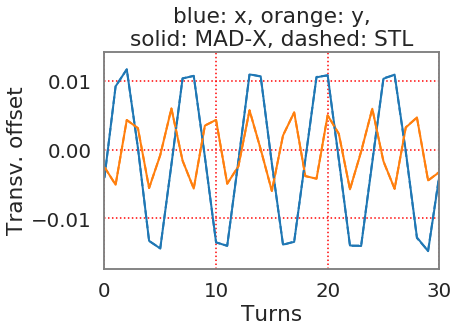

In [50]:
linex, = plt.plot(vx, lw=2)
liney, = plt.plot(vy, lw=2)

plt.plot(rec_x, color=linex.get_color(), ls='--', lw=2)
plt.plot(rec_y, color=liney.get_color(), ls='--', lw=2)
plt.xlim(0, 30)
plt.xlabel('Turns')
plt.ylabel('Transv. offset')
plt.title('blue: x, orange: y,\nsolid: MAD-X, dashed: STL')

Text(0.5, 1.0, 'blue: x, orange: y,\nsolid: MAD-X, dashed: STL')

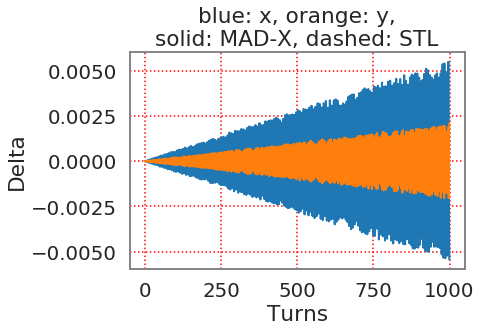

In [52]:
linex, = plt.plot(vx - rec_x, lw=2)
liney, = plt.plot(vy - rec_y, lw=2)
# plt.xlim(0, 30)
plt.xlabel('Turns')
plt.ylabel('Delta')
plt.title('blue: x, orange: y,\nsolid: MAD-X, dashed: STL')

In [40]:
madx.command.eoption(add=True, seed=1)

True

In [41]:
madx.command.exec('EA_EFCOMP_MH()')

True

In [42]:
for s in range(1, 10):
    assert madx.command.exec(f'EA_rEFCOMP_QD({s},1)')

In [43]:
madx.sequence.sis100ring.expanded_elements[2].align_errors

AlignError(dx=-2.1754812916408347e-05, dy=-6.556356908596416e-06, ds=0.0, dphi=0.0, dtheta=0.0, dpsi=0.0, mrex=0.0, mrey=0.0, mredx=0.0, mredy=0.0, arex=0.0, arey=0.0, mscalx=0.0, mscaly=0.0)

In [44]:
elements.get_elements()[:5]

[<Drift at 128
   length:8.1401
 >, <XYShift at 136
   dx:0.0
   dy:-6.556356909e-06
 >, <Multipole at 152
   order:6
   length:0.1444444444
   hxl:0.0
   hyl:0.0
   bal:[ 0.00000000e+00  0.00000000e+00 -3.11548357e-02 -1.31572793e-05
   2.50338393e-06  9.09956036e-06  2.18333224e-03 -4.36536243e-04
  -8.22030465e-03  8.31606062e-03 -6.16459063e-01  1.79624093e-01
  -1.36168364e-02 -1.27669136e+00]
 >, <XYShift at 304
   dx:0.0
   dy:6.556356909e-06
 >, <Drift at 320
   length:0.1462500000000002
 >]

In [46]:
madx.command.readtable(file='../../../vera_sc/noSC_errors/NoSpCh_err_nodipedge/'
                       'matched_NoSC_nodipedge_err_84_73_1', table="twiss1")
twiss1 = madx.table.twiss1

Want to make named table: twiss1


In [47]:
-0.03115598377

-0.03115598377

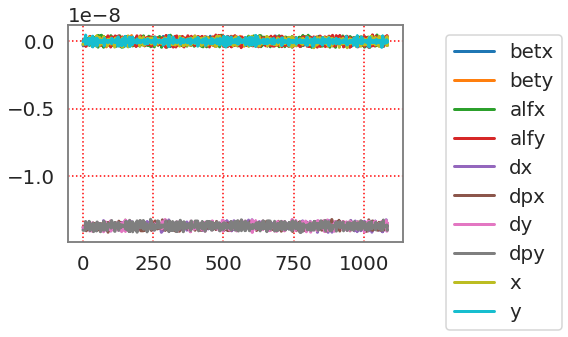

In [48]:
for q in ['betx', 'bety', 'alfx', 'alfy', 'dx', 'dpx', 'dy', 'dpy', 'x', 'y']:
    plt.plot(twiss['s'], (twiss[q] - twiss1[q]) / twiss[q], label=q)
# plt.xlim(0, 50)
plt.legend(bbox_to_anchor=(1.1, 1))

In [49]:
job._particles_buffer.get_object(0)

<Particles at 128
  num_particles:1
  q0:[28.]
  mass0:[2.21695587e+11]
  beta0:[0.56768979]
  gamma0:[1.21470883]
  p0c:[1.52876355e+11]
  s:[1083599.99999503]
  x:[-0.00015391]
  y:[-0.00062041]
  px:[-0.00102319]
  py:[0.00113234]
  zeta:[13.16411008]
  psigma:[-0.00029598]
  delta:[-0.00029601]
  rpp:[1.0002961]
  rvv:[0.99979936]
  chi:[1.]
  charge_ratio:[1.]
  particle_id:[0]
  at_element:[0]
  at_turn:[1000]
  state:[1]
>

In [50]:
!head -54 ../../../vera_sc/noSC_errors/NoSpCh_err_nodipedge/track_NoSC_nodipedge_err_84_73_1_one  | tail -3

In [51]:
#vera = np.loadtxt('../../../vera_sc/noSC_errors/NoSpCh_err_nodipedge/track_NoSC_nodipedge_err_84_73_1_one', skiprows=54)

In [52]:
# vera = np.loadtxt('../../../vera_sc/noSC_errors/NoSpCh_noerr_nodipedge/track_NoSC_nodipedge_noerr_84_73_1_one', skiprows=54)

In [53]:
# np.save('vera_x_y_noerr.npy', np.vstack((vera[0+1000::1000, 2], vera[0+1000::1000, 4])))

In [54]:
Qx = twiss.summary['q1']
qx = Qx % 1
qx = qx if qx < 0.5 else 1 - qx

Qy = twiss.summary['q2']
qy = Qy % 1
qy = qy if qy < 0.5 else 1 - qy

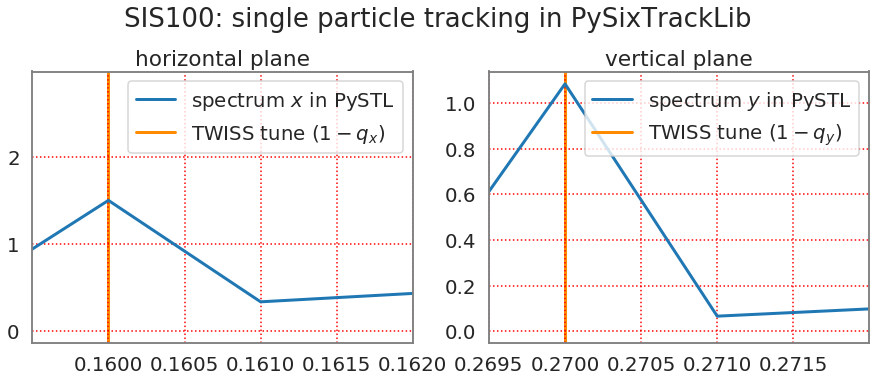

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

plt.sca(ax[0])
plt.title('horizontal plane')
plt.plot(
    np.fft.rfftfreq(len(rec_x)),
    np.abs(np.fft.rfft(rec_x)),
    label=r'spectrum $x$ in PySTL'
)
plt.axvline(qx, color='darkorange', zorder=-1,
            label='TWISS tune $(1-q_x)$')
plt.xlim(qx - 0.0005, qx + 0.002)
plt.legend()

plt.sca(ax[1])
plt.title('vertical plane')
plt.plot(
    np.fft.rfftfreq(len(rec_y)),
    np.abs(np.fft.rfft(rec_y)),
    label=r'spectrum $y$ in PySTL'
)
plt.axvline(qy, color='darkorange', zorder=-1,
            label='TWISS tune $(1-q_y)$')
plt.xlim(qy - 0.0005, qy + 0.002)
plt.legend()

plt.suptitle('SIS100: single particle tracking in PySixTrackLib', y=1.06, fontsize=26);
# plt.savefig('./pystl_sis100_tunes.pdf', bbox_inches='tight')

$\implies$ the alignment errors (offsets and tilts) lead to a finite tune shift